## Configuration

In [1]:
from collections import Counter

import pandas as pd

FANMOD_path = "C:\\Users\\User\\source\\repos\\fanmod-cmd\\out\\build\\x64-release"
FANMOD_exe = "LocalFANMOD.exe"

raw_data_folder = './../../data'
raw_data_folder_dataset = '/melanoma_distance_100_XX'
output_dir = './../../fanmod_output'
cache_dir = './../../parse_cache'
results_dir = './../../results/melanoma_distance_100_XX'
motif_size = 4
iterations = 1000
force_run_fanmod = False
force_parse = False

In [2]:
cells_type = {
    0: 'B cell',
    1: 'CD4 APC',
    2: 'CD4 T cell',
    3: 'CD4 Treg',
    4: 'CD8 T cell',
    5: 'DCs',
    6: 'Germinal Center B cell',
    7: 'Hevs',
    8: 'MAC',
    9: 'Memory CD4 T Cell',
    10: 'NK cell',
    11: 'Neutrophil',
    12: 'Stroma',
    13: 'Tumor',
    14: 'Unidentified',
    15: 'Vessels'
}

Distant_metastases_class = {
    'NP': 'NP',
    'NN': 'NN',
    'PN': 'PN',
    'PP': 'PP',
}

class_to_color = {
    'NP': 'green',
    'NN': 'yellow',
    'PN': 'magenta',
    'PP': 'blue',
}

target_classes_str = 'NN_NP'

## Steps
1. Initiate CISM object
2. Load datasets
3. Initiate CISMTask

In [3]:
from cism.cism import CISM

In [4]:
cism = CISM(fanmod_exe=FANMOD_exe,
            fanmod_path=FANMOD_path,
            network_dataset_root_path=raw_data_folder,
            fanmod_output_root_path=output_dir,
            fanmod_cache_root_path=cache_dir,
            motif_size=motif_size,
            iterations=iterations)

# adding Melanoma dataset
cism.add_dataset(raw_data_folder_dataset, 'Disease', 'Melanoma', force_run_fanmod=force_run_fanmod, force_parse=force_parse, n_jobs=1, quantile_threshold=1)

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [5]:
from cism.cism import TissueStateDiscriminativeMotifs
from cism.cism import DiscriminativeFeatureKey

discriminator = TissueStateDiscriminativeMotifs(cism=cism,
                                                tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
                                                tissue_state_to_string=Distant_metastases_class,
                                                common_cells_type=cells_type)

Here we want to evaluate to compare the following:
1. NP versus PN
2. NP versus PP
3. NN versus PN
4. NN versus PP

In [6]:
discriminator.get_patients_class(classes=None).groupby('patient_class').count()

,patient_class_id
patient_class,
NN,20
NP,18
PN,13
PP,17


When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


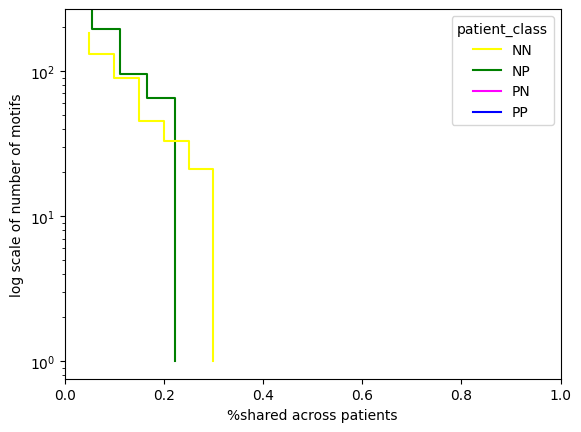

In [7]:
discover_result = discriminator.discover(extract_by=DiscriminativeFeatureKey.CELL_IDENTITIES, classes=['NN', 'NP'])

discover_result.plot_number_of_motifs_versus_shared_percentage(class_to_color=class_to_color)

In [8]:
discover_result.discriminative_motifs.drop(['Patient', 'FOV', 'Freq', 'Count', 'Mean_Freq', 'STD', 'z_score', 'p_value', 'Patient_uId'], axis=1).groupby('ID', observed=True).first().to_csv(results_dir +f'/{target_classes_str}_{motif_size}_color_space_number_of_motifs_versus_shared_percentage.csv')

In [11]:
results_table = None

In [12]:
from cism.cism import HardDiscriminativeFC, SoftDiscriminativeFC, DiscriminativeFeatureKey
import itertools

for left_class, right_class in itertools.combinations(['NN', 'NP'], 2):
    for th in [0.2, 0.22, 0.24, 0.26, 0.28, 0.3]:
        try:
            print(f'task: {left_class} - {right_class}')
            featureConf = HardDiscriminativeFC(
                extract_by=DiscriminativeFeatureKey.CELL_IDENTITIES,
                use_cells_type_composition=True,
                use_motifs=False,
                shared_percentage=th,
                max_class_features=30,
                labels=[left_class, right_class])

            color_space_features = (discriminator
                                    .get_features(feature_conf=featureConf,
                                                  exclude_patients=[],
                                                  n_jobs=1))

            optimal_result = (discriminator
                              .analyze_motifs(feature_conf=featureConf,
                                              exclude_patients=[],
                                              n_jobs=1))

            print(f'classes: {[left_class, right_class]} '
                  f'th:{th} score: {optimal_result.get_roc_auc_score()}')

            all_color_space_features = []
            for idx, row in color_space_features.iterrows():
                all_color_space_features += row['features']
            all_color_space_features = list(set(all_color_space_features))

            color_space_freq = []
            color_space_count = []
            motifs_dataset = discriminator.cism.motifs_dataset
            for colors_vec_hash in all_color_space_features:
                color_space_mean_freq = motifs_dataset[motifs_dataset['colors_vec_hash'] == colors_vec_hash]['Freq'].mean()
                color_space_mean_count = motifs_dataset[motifs_dataset['colors_vec_hash'] == colors_vec_hash]['Count'].mean()
                color_space_freq.append(color_space_mean_freq)
                color_space_count.append(color_space_mean_count)

            results_table = pd.concat([pd.DataFrame(
                                            {'th': th,
                                             'task': left_class + '-' + right_class,
                                             'left_class': left_class,
                                             'right_class': right_class,
                                             'roc_auc_score': optimal_result.get_roc_auc_score(),
                                             'all_color_space_features': all_color_space_features,
                                             'color_space_freq': color_space_freq,
                                             'color_space_count': color_space_count}),
                                             results_table], ignore_index=True)
        except Exception as e:
            print(e.with_traceback())
            break

task: NN - NP


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

classes: ['NN', 'NP'] th:0.2 score: 0.20833333333333331
task: NN - NP


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

classes: ['NN', 'NP'] th:0.22 score: 0.25555555555555554
task: NN - NP


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

classes: ['NN', 'NP'] th:0.24 score: 0.17222222222222222
task: NN - NP


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

classes: ['NN', 'NP'] th:0.26 score: 0.18333333333333335
task: NN - NP


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

TypeError: BaseException.with_traceback() takes exactly one argument (0 given)

In [ ]:
results_table.to_csv(results_dir+f'/benchmark_across_th_NN_NP_color_space_{motif_size}_max_motifs.csv')